# Development of XGBoost Classifier
- Datasources: 
    - the provided testset
    - the MIT-BIH Arrhythmia Database (https://physionet.org/content/mitdb/1.0.0/)
<br>
- Processing:
    - Neurokit2 (https://neuropsychology.github.io/NeuroKit/)

In [1]:
#import moduls
import csv
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import neurokit2 as nk
import pandas as pd
import scipy
import utilz
from audiomentations import Compose, AddGaussianNoise, TimeStretch, TimeMask, Shift, Resample
import pickle

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## Data exploration with Neurokit2

(9000, 1)
(9000,)


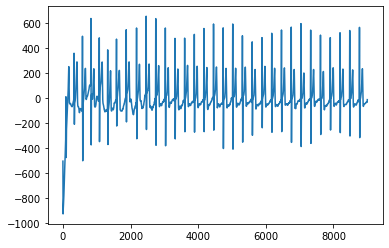

In [117]:
#load one example signal
data = sio.loadmat('training/'+'train_ecg_00002'+'.mat')
signal = data['val'].T
print(signal.shape)
signal = np.ravel(signal)
print(signal.shape)
plt.plot(signal) 
plt.show()

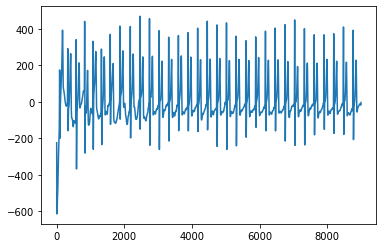

In [3]:
#clean the signal with neurokit ecg_clean
fs = 300
signal_cleaned = nk.ecg_clean(signal, sampling_rate=fs)
plt.plot(signal_cleaned) 
plt.show()

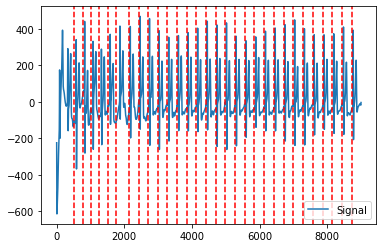

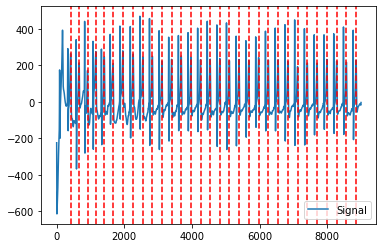

In [4]:
#detect peaks
_, rpeaks = nk.ecg_peaks(signal_cleaned, sampling_rate=fs)
signals, waves = nk.ecg_delineate(signal_cleaned, rpeaks, sampling_rate=fs)
nk.events_plot(waves["ECG_P_Peaks"], signal_cleaned);
nk.events_plot(waves["ECG_T_Peaks"], signal_cleaned);

(1, 72)
(1, 78)


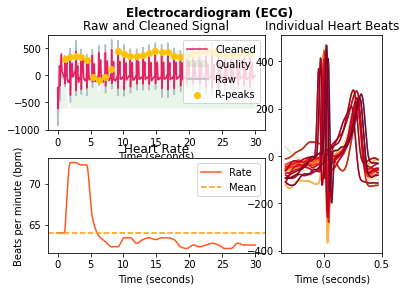

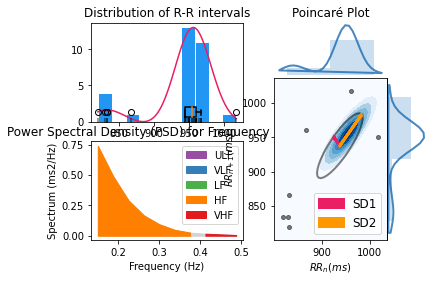

In [118]:
#using the processing of neurokit to show which information can be retrieved
signals, info = nk.ecg_process(signal, sampling_rate=fs, method='neurokit')
nk.ecg_plot(signals, sampling_rate=fs, show_type='default') 
analyzed = nk.ecg_analyze(signals, sampling_rate=fs)
peaks, info = nk.ecg_peaks(signal, sampling_rate=fs)
hrv_indices = nk.hrv(peaks,sampling_rate=fs, show=True)
print(hrv_indices.shape)
print(analyzed.shape)

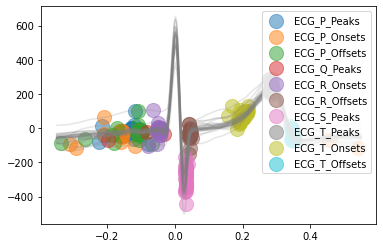

In [119]:
_, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
signal_dwt, waves_dwt = nk.ecg_delineate(signal, rpeaks, sampling_rate=fs, method="dwt", show=True, show_type='all')

In [181]:
#using all features of ecg_analyze and writing them to one dataframe
dataFrame = pd.DataFrame();
signals, info = nk.ecg_process(signal, sampling_rate=fs, method='neurokit')
analyzed = nk.ecg_analyze(signals, sampling_rate=fs)
analyzed.head
analyzed['TYPE'] = "A"
PQframe=pd.DataFrame(PQ, index=[0])
pd.concat([analyzed,PQframe], axis=1)
analyzed.head

c:\Users\timen\Anaconda3\envs\KIMed\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
c:\Users\timen\Anaconda3\envs\KIMed\lib\site-packages\neurokit2\complexity\entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)


<bound method NDFrame.head of    ECG_Rate_Mean  HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0       64.01005  937.666667  44.833878         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD  ...  HRV_ShanEn  \
0         NaN         NaN         NaN  17.573055  ...    3.257426   

   HRV_FuzzyEn  HRV_MSE  HRV_CMSE  HRV_RCMSE    HRV_CD   HRV_HFD   HRV_KFD  \
0     0.465767      NaN       NaN        NaN  0.593065  1.142019  1.190573   

    HRV_LZC  TYPE  
0  0.981378     A  

[1 rows x 74 columns]>

## import and processing
The used signals are preprocessed with Neurokit2 and saved. This allows for faster training afterwards.
The features used for training consist of features directly extract from Neurokit2 and features calculated by us (see utilz.py) based on the peak detection provied by Neurokit2.
Features from Neurokit2 have been used for classification problems.
- e.g. Wong, Alexander W., et al. "Multilabel 12-lead electrocardiogram classification using gradient boosting tree ensemble." 2020 Computing in Cardiology. IEEE, 2020.


The features we calculat addiontally are based on:
- D. U. Uguz, F. Berief, S. Leonhardt and C. H. Antink, "Classification of 12-lead ECGs Using Gradient Boosting on Features Acquired With Domain-Specific and Domain-Agnostic Methods," 2020 Computing in Cardiology, 2020, pp. 1-4, doi: 10.22489/CinC.2020.363.


All the addionally calculated features are based on the time between different distinctiv signal parts in an ecg like the Q,R,S-peaks.
Afterwards, we calculate some staticial values (mean, min, max, std, skewness) based on
- Kropf M, Hayn D and Schreier Gennter 2017 ECG Classification Based on Time and Frequency Domain Features Using Random Forrests [C] Computing in Cardiology Conference

To increase the amount of data we can train our model on we used data augmentation to add gausian noise, resampling and other opitons provided by https://github.com/iver56/audiomentations.

For details of the implmentation take a look at utilz.py!

In [23]:
# import and processing of the provided training data

augment_singnals = True #change this variable if you want to process the data without augmentation

import warnings
warnings.filterwarnings('ignore') #Neurokit throws some warnings if signals are short, this helps to suppress them.

fs = 300 
analyzed_list = []
with open('dftemplate.pkl','rb') as target:
        dftemplate = pickle.load(target)  #Template dataframe that contains all the features we are using
with open('training/REFERENCE.csv') as csv_file:      
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if(row[1]=='N' or row[1]=='A'): #only importing files for normal and afib signals
            data = sio.loadmat('training/'+row[0]+'.mat')   # Import der EKG-Dateien
            signal = data['val'][0]
            try:
                signal_list = []
                signal_list.append(signal)
                if(augment_singnals):   #augmenting each imported signal 3 times 
                    for i in range(3):
                        signal_list.append(utilz.augment_signal(signal,fs))
                        i = i+1
                for signal in signal_list:  #extracting the features and saving them in a dataframe
                    signals, info = nk.ecg_process(signal, sampling_rate=fs, method='neurokit')
                    analyzed = nk.ecg_analyze(signals, sampling_rate=fs)
                    analyzed = pd.concat([analyzed,utilz.ownFeatures(signals)], axis=1)
                    analyzed = pd.concat([dftemplate,analyzed], axis=0)
                    analyzed = analyzed[dftemplate.columns.to_list()].iloc[1].to_frame().T
                    analyzed['TYPE'] = ''
                    if row[1]=='N':
                        analyzed['TYPE'] = 'N'        
                    if row[1]=='A':
                        analyzed['TYPE'] = 'A'        
                    analyzed_list.append(analyzed)
            except:
                print(line_count) #some signals cannot be processed by Neurokit2, these are filtered out
        line_count = line_count + 1
df_augmented = pd.concat(analyzed_list, axis=0) #building the final dataframe

189
195
339
477
524
591
603
640
843
964
1048
1307
1366
1402
1438
1491
1496
1531
1571
1887
1953
1954
2005
2034
2053
2128
2223
2464
2501
2508
2527
2739
2970
2974
2978
2996
3022
3040
3057
3061
3063
3115
3162
3168
3304
3309
3354
3414
3417
3448
3471
3512
3528
3623
3793
4058


In [24]:
df_augmented.to_pickle('./Neurokit_Dataset_augmented.pkl') #save dataframe

In [27]:
df_augmented = pd.read_pickle('./Neurokit_Dataset_augmented.pkl') #load dataframe
df_augmented.info

<bound method DataFrame.info of     ECG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  \
0       58.230248  1039.404762  231.216240         NaN         NaN   
0       53.655855  1119.358974  111.702061         NaN         NaN   
0       51.746536  1160.533333   61.128886         NaN         NaN   
0       56.525713  1067.407407  215.411221         NaN         NaN   
0       64.010050   937.666667   44.833878         NaN         NaN   
..            ...          ...         ...         ...         ...   
0      162.622610   369.156118   34.745589         NaN         NaN   
0       81.872131   733.166667   30.512713         NaN         NaN   
0       81.872131   733.166667   30.512713         NaN         NaN   
0       82.022575   731.709402   32.307657         NaN         NaN   
0       82.269388   730.854701   33.137300         NaN         NaN   

    HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  \
0          NaN         NaN         NaN         NaN  212.

In [9]:
# import and processing of the MIT-BIH dataset
augment_singnals = True #change this variable if you want to process the data without augmentation

import warnings
warnings.filterwarnings('ignore') #Neurokit throws some warnings if signals are short, this helps to suppress them.
fs = 300 
analyzed_list = []
with open('dftemplate.pkl','rb') as target:
        dftemplate = pickle.load(target) #Template dataframe that contains all the features we are using
with open('ProcessedData/MIT-AtrialFibrillation/REFERENCE.csv') as csv_file:      
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if((row[1]=='N' or row[1]=='A') and line_count%4 == 0): #only importing files for normal and afib signals and only every 4th signal to match the size of the provided dataset
            data = sio.loadmat('ProcessedData/MIT-AtrialFibrillation/'+row[0]+'.mat')   # Import der EKG-Dateien
            signal = data['val'][0]
            try:
                signal_list = []
                signal_list.append(signal)
                if(augment_singnals):
                    for i in range(3):
                        signal_list.append(utilz.augment_signal(signal,fs)) #augmenting each imported signal 3 times
                        i = i+1
                for signal in signal_list: #extracting the features and saving them in a dataframe
                    signals, info = nk.ecg_process(signal, sampling_rate=fs, method='neurokit')
                    analyzed = nk.ecg_analyze(signals, sampling_rate=fs)
                    analyzed = pd.concat([analyzed,utilz.ownFeatures(signals)], axis=1)
                    analyzed = pd.concat([dftemplate,analyzed], axis=0)
                    analyzed = analyzed[dftemplate.columns.to_list()].iloc[1].to_frame().T
                    analyzed['TYPE'] = ''
                    if row[1]=='N':
                        analyzed['TYPE'] = 'N'        # Zuordnung zu "Normal"
                    if row[1]=='A':
                        analyzed['TYPE'] = 'A'             # Zuordnung zu "Vorhofflimmern"
                    analyzed_list.append(analyzed)
            except:
                print(line_count) #some signals cannot be processed by Neurokit2, these are filtered out
        line_count = line_count + 1
df_mit_augmented = pd.concat(analyzed_list, axis=0) #building the final dataframe

152
160
188
276
348
364
376
460
552
588
596
608
656
792
852
956
996
1116
1144
1148
1152
1236
1264
1480
1596
1624
1712
1716
1720
1764
1800
1856
1864
1888
1896
1948
1960
1996
2028
2112
2160
2184
2200
2260
2324
2448
2464
2604
2616
2624
2656
2704
2760
2800
2860
2872
2960
2980
3008
3020
3172
3176
3276
3296
3304
3308
3344
3360
3380
3424
3480
3576
3800
4052
4056
4124
4136
4140
4184
4252
4276
4292
4304
4420
4448
4452
4632
4704
4744
4844
4856
4880
4908
4928
4936
4976
4980
5004
5052
5088
5144
5148
5160
5172
5268
5280
5292
5396
5480
5712
5716
5732
5812
5916
6032
6068
6120
6192
6208
6468
6480
6584
6592
6664
6684
6700
6704
6776
6792
7128
7148
7168
7432
7440
7612
7640
7660
7772
7776
7796
7884
7896
7908
8012
8044
8096
8124
8200
8268
8404
8436
8476
8568
8588
8624
8680
8704
8956
8988
9084
9116
9144
9152
9172
9196
9208
9232
9320
9332
9364
9492
9516
9604
9616
9672
9688
9772
9780
9860
9872
9948
10072
10128
10144
10216
10224
10232
10236
10260
10288
10312
10324
10332
10344
10416
10420
10448
10472
10504
1052

In [10]:
df_mit_augmented.info

<bound method DataFrame.info of     ECG_Rate_Mean  HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      109.397274  554.444444  159.809620         NaN         NaN         NaN   
0      109.397274  554.444444  159.809620         NaN         NaN         NaN   
0      103.202610  587.698413  169.530658         NaN         NaN         NaN   
0      109.397274  554.444444  159.809620         NaN         NaN         NaN   
0      102.392228  601.666667  207.863916         NaN         NaN         NaN   
..            ...         ...         ...         ...         ...         ...   
0      115.454984  533.137255  193.693883         NaN         NaN         NaN   
0      128.935031  467.902622   76.403339         NaN         NaN         NaN   
0      124.360707  485.056180   78.887646         NaN         NaN         NaN   
0      127.442820  472.916667   79.705416         NaN         NaN         NaN   
0      127.434712  472.916667   79.705416         NaN         NaN         NaN

In [11]:
df_mit_augmented.to_pickle('./MIT_Dataset_augmented.pkl')

In [82]:
#df_mit.to_pickle('./MIT_Dataset.pkl')

In [46]:
#df_mit = pd.read_pickle('./MIT_Dataset.pkl')

In [12]:
#df.to_pickle('./Neurokit_Dataset.pkl')

# Training the model

The model is implemented with: https://xgboost.readthedocs.io/en/stable/.

In [45]:
#run either this cell to train WITHOUT augmented data
df = pd.read_pickle('./Neurokit_Dataset.pkl')
df_mit = pd.read_pickle('./MIT_Dataset.pkl')
df_train = df

In [93]:
#or run this cell to train WITH augmented data
df = pd.read_pickle('./Neurokit_Dataset_augmented.pkl')
df_mit = pd.read_pickle('./MIT_Dataset_augmented.pkl')
df_train = df

In [94]:
# build on dataframe for training
df_train = pd.concat([df,df_mit],axis=0)
df_shuffled = df_train.sample(frac=1).reset_index(drop=True)
df_shuffled.info
df_train = df_shuffled

In [95]:
# change labels to 0 and 1 
df_train = df_train.replace('N', 0)
df_train = df_train.replace('A', 1)
# change all infinty values to nan's that can be handled by xgboost
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)


In [97]:
df_train.info

<bound method DataFrame.info of        ECG_Rate_Mean  HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  \
0          79.182505  770.277778  253.172941         NaN         NaN   
1          89.525831  670.310078   22.757218         NaN         NaN   
2         116.458597  522.677596  119.250467         NaN         NaN   
3         111.067549  542.674419   68.174746         NaN         NaN   
4          93.597540  663.106061  274.622031         NaN         NaN   
...              ...         ...         ...         ...         ...   
38420     121.668656  492.936508   10.571793         NaN         NaN   
38421      74.567587  804.761905   37.112093         NaN         NaN   
38422      77.093564  804.607843  594.802412         NaN         NaN   
38423      79.463816  755.724638   52.237175         NaN         NaN   
38424      59.988805  999.655172   40.486573         NaN         NaN   

       HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  \
0             NaN         NaN

In [96]:
#since the dataset is highly unbalanced we calculate the ratio of afib signals to normal signals, which is later used in training
numtyp0 = len(df_train[df_train['TYPE']==0]['TYPE'])
numtyp1 = len(df_train[df_train['TYPE']==1]['TYPE'])

weight = numtyp0 / numtyp1
print(weight)

3.076490558030978


In [5]:
#show the correlation between the features and our target
correlation = df.corr()
correlation = correlation['TYPE']
print(correlation.to_string())

ECG_Rate_Mean              0.457491
HRV_MeanNN                -0.347755
HRV_SDNN                   0.274709
HRV_SDANN1                      NaN
HRV_SDNNI1                      NaN
HRV_SDANN2                      NaN
HRV_SDNNI2                      NaN
HRV_SDANN5                      NaN
HRV_SDNNI5                      NaN
HRV_RMSSD                  0.335730
HRV_SDSD                   0.333469
HRV_CVNN                   0.446846
HRV_CVSD                   0.511722
HRV_MedianNN              -0.394098
HRV_MadNN                  0.413784
HRV_MCVNN                  0.576699
HRV_IQRNN                  0.345607
HRV_pNN50                  0.625069
HRV_pNN20                  0.503470
HRV_HTI                    0.475110
HRV_TINN                   0.086969
HRV_ULF                         NaN
HRV_VLF                         NaN
HRV_LF                     0.191661
HRV_HF                     0.314499
HRV_VHF                    0.416589
HRV_LFHF                  -0.155001
HRV_LFn                   -0

In [99]:
# split the dataframe into labels and features
y_comp = df_train['TYPE']
X_comp = df_train.drop('TYPE', axis=1)

In [100]:
#create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_comp, y_comp, test_size=0.2, random_state=99, shuffle=True)

In [109]:
#build the classifier
classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators = 500, seed =123, scale_pos_weight =weight)

In [101]:
#optimiesed paramters from gridsearch to prevent overfitting

parameters = {'nthread':[4],
              'objective':['binary:hinge'],
              'learning_rate': [0.2], 
              'max_depth': [8],
              'min_child_weight': [20],
              'silent': [1],
              'subsample': [0.5],
              'colsample_bytree': [0.3],
              'n_estimators': [13],
              'missing':[-999],
              'booster':['dart'],
              'seed': [1337]}

In [110]:

#Grid search to train the classifer 
clf = GridSearchCV(classifier, parameters, n_jobs=5, 
                   cv=8,
                   scoring='f1_micro',
                   verbose=2, refit=True)

clf.fit(X_train,y_train)


Fitting 8 folds for each of 1 candidates, totalling 8 fits
[16:06:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=8,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=5,
             p

In [111]:
#show results of gridsearch
classifier = clf.best_estimator_
clf.best_params_

{'booster': 'dart',
 'colsample_bytree': 0.3,
 'learning_rate': 0.2,
 'max_depth': 8,
 'min_child_weight': 20,
 'missing': -999,
 'n_estimators': 13,
 'nthread': 4,
 'objective': 'binary:hinge',
 'seed': 1337,
 'silent': 1,
 'subsample': 0.5}

In [113]:
#Test classifier on the test set
predict = classifier.predict(X_test)
accuracy= float(np.sum(predict==y_test))/y_test.shape[0]
print(accuracy)

0.9795705920624593


In [114]:
classifier.save_model('xgboost_augmented.json') #save model 

98
mit
0.9595322351027049
0.959731543624161
[[192   4]
 [  8  94]]


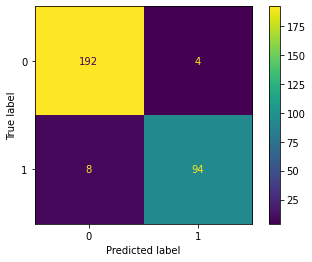

In [115]:
#test classifier on our validation set from the MIT-BIH set
#run predict_pretrained.py with the current model beforehand!
import utilz
from sklearn.metrics import ConfusionMatrixDisplay
f1, acc,cm = utilz.predictions_score('./ProcessedData/MIT_AF_val/REFERENCE.csv','./PREDICTIONS.csv')
print('mit')
print(f1)
print(acc)
print(cm)
cm = ConfusionMatrixDisplay(cm)
cm.plot()